# Librerias, semilla y funciones 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm


from sklearn.metrics import accuracy_score, balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix, f1_score



### Constantes:
seed=123


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
sys.path.append('../src')
import funciones as f
sys.path.remove('../src')

In [3]:
df_train = pd.read_csv('../data/df_train_scaled.csv')
df_test = pd.read_csv('../data/df_test_scaled.csv')

# Separar las características y la variable objetivo

X_test = df_test.iloc[:, :-1]  # Todas las columnas excepto la última
y_test = df_test.iloc[:, -1]    # Última columna (variable objetivo)


# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('TARGET', axis=1), df_train['TARGET'], 
                                                  test_size=0.2, random_state=42  # 20% para validación
)

In [4]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

# 1. - Primera comparación de modelos (sin tratar desbalanceos)

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Lista de clasificadores
classifiers = [
    DummyClassifier(),  # Ejemplo con estrategia
    LogisticRegression(),         # Aseguramos convergencia
    GaussianNB(),                              # Naive Bayes
    DecisionTreeClassifier(),                  # Árbol de decisión
    RandomForestClassifier(),   # Random Forest
    XGBClassifier(),  # XGBoost
    LGBMClassifier()                           # LightGBM
]


In [6]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    y_pred = pipe.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(X_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier()
model score: 0.920

    accuracy = 0.9203284419332547
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45282     0]
 [ 3920     0]]
    
LogisticRegression()
model score: 0.920

    accuracy = 0.920430063818544
    precision = 0.5301204819277109
    recall = 0.011224489795918367
    f1_score = 0.021983512365725703
    confusion matrix:
    [[45243    39]
 [ 3876    44]]
    
GaussianNB()
model score: 0.730

    accuracy = 0.7296654607536279
    precision = 0.14930841121495328
    recall = 0.5094387755102041
    f1_score = 0.23093379589476726
    confusion matrix:
    [[33904 11378]
 [ 1923  1997]]
    
DecisionTreeClassifier()
model score: 0.853

    accuracy = 0.8527498882159262
    precision = 0.1437754446110992
    recall = 0.1711734693877551
    f1_score = 0.156282752998719
    confusion matrix:
    [[41286  3996]
 [ 3249   671]]
    
RandomForestClassifier()
model score: 0.920

    accuracy = 0.9202674688020812
    precision = 0

# 1.1. - GaussianNB - Naive Bayes

A priori de entre estos modelos vanilla el que mejor funciona es el Gaussiano. De base ya nos está dando un 50% de recall sacrificando un poco de precisión. El score que recibe es el más bajo de los modelos pero es el que mejor predice la clase minoritaria, que es lo que más le interesa a un banco, ser capaz de predecir que clientes no van a poder pagar, por ello vamos a seguir con el.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, f1_score, recall_score, fbeta_score

# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(X_val)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred)  
f2_score = fbeta_score(y_val, y_pred, beta=2)  
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8077689951038162
Accuracy en el conjunto de validación: 0.7636
Recall en el conjunto de validación: 0.4704
F2-Score en el conjunto de validación: 0.3405


Hemos mejorado la precisión pero a cambio de recall. Hemos conseguido unos resultados bastante normalitos aún con el fine-tuning. El problema de este tipo de modelo es que al contar con muy pocos hiperparámetros, no va a mejorar demasiado según se combinen ya que hay pocas opciones. De todas formas voy a analizar las ventajas y dsventajas de este modelo buscando alguna forma de poder mejorar el resultado.

Ventajas: 
- Eficiencia computacional: Es extremadamente rápido de entrenar y predecir porque solo requiere el cálculo de estadísticas básicas.
- Escalabilidad: Escala bien con datos grandes.
- Interpretabilidad: Fácil de entender y explicar.
- Requiere pocos datos: Funciona bien con datasets pequeños o moderados.

Desvenatajas: 
- Se basa en que las variables son independientes --> revisar interdependencia de las variales 
- Requiere una distribución Gaussiana 
- Sensibilidad a los valores atípicos 

Viendo estas limitaciones que tiene, es conveniente revisar si nuestros datos de adaptan bien a ellas.Estas 2 últimas limitaciones ya se solucionaron con el procesos de estandarización que realizamos en '03_Feature_Processing.ipynb', por lo que no debería suponer un problema. En cuanto a la independencia de las varaibles había algunas que estaban muy correlacionadas cuando lo estudiamos en el notebook 2.

Por esto vamos revisar correlaciones e independencias y valorar posteriormente la eliminación de algunas variables y ver si así el resultdao mejora.


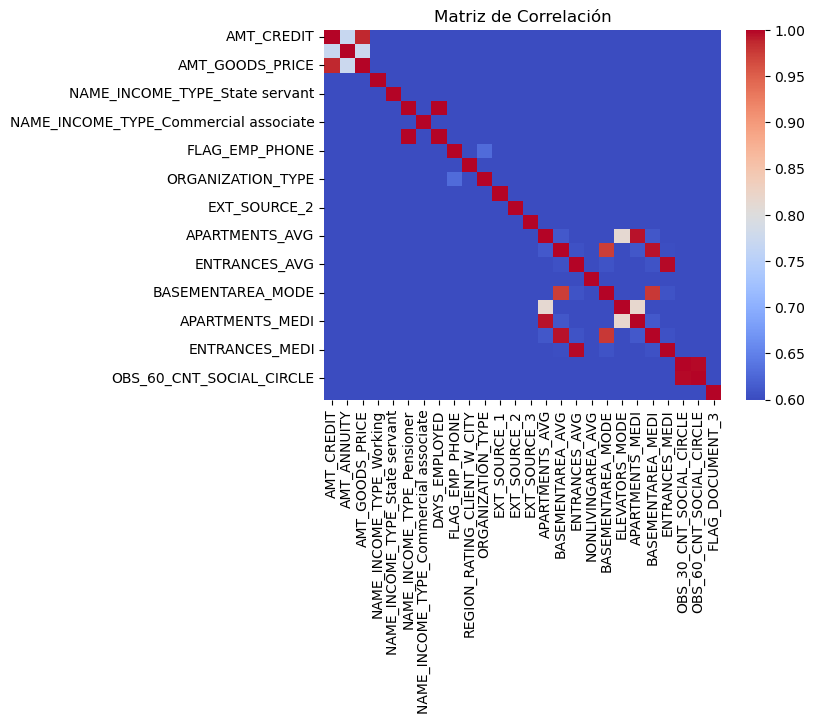

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, vmin=0.6, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
new_corr = correlation_matrix.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
215,FLAG_EMP_PHONE,DAYS_EMPLOYED,0.999784
213,FLAG_EMP_PHONE,NAME_INCOME_TYPE_Pensioner,0.999500
187,DAYS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,0.999489
647,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998378
588,ENTRANCES_MEDI,ENTRANCES_AVG,0.996899
534,APARTMENTS_MEDI,APARTMENTS_AVG,0.995028
561,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,0.994900
52,AMT_GOODS_PRICE,AMT_CREDIT,0.986484
564,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,0.977616
483,BASEMENTAREA_MODE,BASEMENTAREA_AVG,0.973741


Como se puede ver hay unas cuantas variables que están relacionadas casi al 100%. Voy a ir seleccionando en cada pareja de variables la que voy a eliminar en función de: 
- Cual es más difícil de interpretar --> 'FLAG_EMP_PHONE'
- Que información es menos útil, por ejemplo he decidod eliminar lo casos de '_MODE'

Después de realizar esto, voy a volver a tirar el modelo y evaluaré si existe algún tipo de mejora

In [27]:
lista_eliminar = ['FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ENTRANCES_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                  'AMT_GOODS_PRICE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MODE']

# Eliminar columnas del conjunto de entrenamiento y prueba
X_train_reduced = X_train.drop(columns=lista_eliminar)
X_test_reduced = X_test.drop(columns=lista_eliminar)
X_val_reduced = X_val.drop(columns=lista_eliminar)

assert list(X_train_reduced.columns) == list(X_test_reduced.columns), "Los conjuntos no tienen las mismas columnas."

In [28]:
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_reduced shape: {X_val_reduced.shape}")
print(f"y_val shape: {y_val.shape}")
print(X_val.shape)


X_train_reduced shape: (196806, 18)
y_train shape: (196806,)
X_val_reduced shape: (49202, 18)
y_val shape: (49202,)
(49202, 26)


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, f1_score, recall_score, fbeta_score

# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(X_train_reduced, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(X_val_reduced)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred,) 
f2_score = fbeta_score(y_val, y_pred, beta=2) 
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8765154070540891
Accuracy en el conjunto de validación: 0.8777
Recall en el conjunto de validación: 0.2467
F2-Score en el conjunto de validación: 0.2453

Matriz de confusión:
[[42216  3066]
 [ 2953   967]]


Los resultados conseguidos tras eliminar las columnas dependientes han empeorado claramente. La precisión ha aumentado en 7 puntos pero el recall, la medida objetivo, se ha desplomado. Voy a dejar este modelo aquí porque no veo forma de poder mejorarlo. 

Es un modelo simple que de primeras ha dado unos resultados que parecian buenos. El problema que presenta es precisamente eso, su simpleza, al no tener parámetros que ayuden a que se adapte a cada caso hace que la cantidad de mejora sea muy baja.

En base a esto y analizando un poco cada modelo, el que voy a tratar de optimizar ahora es el XGBoost. Aunque inicialmente sus resultados no destacan (la mayoría han tenido resultados similares) creo que su capacidad de optimización gracias a distintos parámetros puede hacer que se adapte bien al problema.

# 2. - Oversampling y undersampling

Antes de seguir, me he dado cuenta, de que en este caso, no se si será así siempre, es necesario realizar un tratamiento del desbalanceo. Los modelos son prácticamente inútiles con muestras tan desbalanceadas, de hecho, cuando se intentan añadir parámetros prácticamente siempre generan overfitting. 

Concluyendo, en este caso e imagino que en muchos otros, no se puede trabajar con un desbalanceo como el que hay, por ello voy a proceder a tratarlo. Existen 2 opciones a nivel general, undersampling y oversampling.

Considero que en este caso es necesario una combinación de ambas

Como tenemos una muestra muy desbalanceada, es casi imposible evitar el overfitting, por ello voy a probar a métodos de undersampling y oversampling.

- RandomOverSampler: Duplica aleatoriamente muestras de la clase minoritaria. Simple pero puede inducir sobreajuste.
- SMOTE (Synthetic Minority Oversampling Technique): Genera nuevos ejemplos sintéticos basados en vecinos cercanos. Es más robusto que el duplicado directo.
- ADASYN: Variante de SMOTE que enfoca la generación de ejemplos en las áreas más difíciles de clasificar.
- Borderline-SMOTE: Genera datos sintéticos cerca de las fronteras entre clases

In [57]:
from imblearn.over_sampling import SMOTE

# Configurar SMOTE
smote = SMOTE(
    sampling_strategy=0.4,  # La clase minoritaria será el 50% de la mayoritaria
    k_neighbors=4,          # Usar 4 vecinos para interpolación
    random_state=seed,        # Reproducibilidad
    n_jobs=-1               # Usar todos los núcleos disponibles
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()/ len(y_train_resampled)


TARGET
0    0.714287
1    0.285713
Name: count, dtype: float64

In [58]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=seed)
X_resampled, y_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
values = y_resampled.value_counts()/len(y_resampled)

print(len(y_train))
print(len(y_train_resampled))
print(len(y_resampled))
print(values)

196806
253212
192922
TARGET
0    0.624999
1    0.375001
Name: count, dtype: float64


He estado probando distintas combinaciones de undersampling y oversampling con el objetivo de poder mejorar el recall de los modelos sin perder excesiva precisión.

# 3. - Evaluación modelos (clases balanceadas)

# 3.1. - Modelos Vanilla

In [59]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_resampled, y_resampled)   
    y_pred = pipe.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(X_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier()
model score: 0.920

    accuracy = 0.9203284419332547
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45282     0]
 [ 3920     0]]
    
LogisticRegression()
model score: 0.815

    accuracy = 0.814540059347181
    precision = 0.2025374328494685
    recall = 0.4520408163265306
    f1_score = 0.2797379430104981
    confusion matrix:
    [[38305  6977]
 [ 2148  1772]]
    
GaussianNB()
model score: 0.481

    accuracy = 0.4805292467785862
    precision = 0.1034634414513469
    recall = 0.7201530612244897
    f1_score = 0.18093254286172086
    confusion matrix:
    [[20820 24462]
 [ 1097  2823]]
    
DecisionTreeClassifier()
model score: 0.778

    accuracy = 0.7781594244136417
    precision = 0.12549523503587107
    recall = 0.29897959183673467
    f1_score = 0.17678557960630514
    confusion matrix:
    [[37115  8167]
 [ 2748  1172]]
    
RandomForestClassifier()
model score: 0.896

    accuracy = 0.8955327019226861
    precision = 0.

# 3.2.1. -LogisticRegression

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score

# Configurar el Pipeline
lr_pipeline = Pipeline(steps=[('classifier', LogisticRegression(random_state=seed, max_iter=1000))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],      # Coeficiente de regularización
    'classifier__penalty': ['l1', 'l2', None],  # Tipo de regularización
    'classifier__solver': [ 'saga'],   # Solvers compatibles con regularización
    'classifier__l1_ratio': [0.2, 0.5, 0.8]       # Solo para 'elasticnet'
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring=make_scorer(f1_score, average='weighted'),  # Métrica de evaluación
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)
y_pred = CV.predict(X_val)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificación
print(classification_report(y_val, y_pred))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  w

[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min
[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.8, classifier__penalty=None, classifier__solver=saga; total time= 3.0min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 3.0min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  war

[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 2.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 2.9min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 2.9min
[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=None, classifier__solver=saga; total time= 2.9min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  war

[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[CV] END classifier__C=10, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min
[CV] END classifier__C=10, classifier__l1_ratio=0.5, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  56.8s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  58.2s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.3s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.7s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time= 1.0min
[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.8s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.8s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.9s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.9s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__penalty=l2, classifier__solver=saga; total time=  59.8s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  50.7s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  51.5s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  51.9s
[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  51.9s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 5.7min
[CV] END classifier__C=1, classifier__l1_ratio=0.2, classifier__penalty=l1, classifier__solver=saga; total time= 5.7min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.7min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  58.6s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  58.3s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.9s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.7s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.1s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min
[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.2s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__l1_ratio=0.8, classifier__penalty=l1, classifier__solver=saga; total time= 5.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.4s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.2s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.1s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  11.1s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  10.9s
[CV] END classifier__C=0.01, classifier__l1_ratio=0.2, classifier__penalty=l2, classifier__solver=saga; total time=  10.8s


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.8min
[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.8min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.7min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.7min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.6min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.6min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__penalty=None, classifier__solver=saga; total time= 2.4min
Mejores parámetros: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.2, 'classifier__C': 1}
Mejor score: 0.6872856398642759
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     45282
           1       0.20      0.46      0.28      3920

    accuracy                           0.81     49202
   macro avg       0.57      0.65      0.59     49202
weighted avg       0.89      0.81      0.84     49202



# 3.2.2 - Árbol de decisión

In [54]:
def custom_recall_metric(y_val, y_pred):
    from sklearn.metrics import recall_score
    return recall_score(y_val, y_pred)

# Configurar el Pipeline
dt_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],         # Función de evaluación para los nodos
    'classifier__max_depth': [3, 5, 10, None],           # Profundidad máxima del árbol
    'classifier__min_samples_split': [2, 5, 10],         # Número mínimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [1, 2, 4],           # Número mínimo de muestras en una hoja
    'classifier__max_features': [None, 'sqrt', 'log2'],  # Número máximo de características a considerar
    'classifier__max_leaf_nodes': [None, 10, 20, 50],    # Número máximo de nodos hoja
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring= make_scorer(f1_score), 
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)
y_pred = CV.predict(X_val)


# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)
print(classification_report(y_val, y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   1.3s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   1.4s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   1.5s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   1.1s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__m

In [30]:
recall_score(y_val, y_pred)

0.5135204081632653

# 3.2.3. - XGBClassifier

In [36]:
# Configurar el Pipeline
xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier( eval_metric='logloss'))])

# Definir el espacio de hiperparámetros

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],                 # Poca profundidad --> evitar overfitting
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],           # Fracción de datos usados por cada árbol
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],    #  Fracción de características usadas por árbol
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__gamma': [0, 0.1, 0.2],
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring= make_scorer(recall_score),
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

CV.predict(X_val)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

print(classification_report(y_val, y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=   9.0s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=   9.2s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=   9.6s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=  10.1s
[CV] END 

In [34]:
recall_score(y_val, y_pred)
accuracy_score(y_val,y_pred)

0.6675338400878013

# 3.2.4. - LightGMB

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Configurar el Pipeline
lgbm_pipeline = Pipeline(steps=[('classifier', LGBMClassifier(random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200, 300],       # Número de árboles
    'classifier__max_depth': [3, 5, 7, -1],           # Profundidad máxima (-1 para sin límite)
    'classifier__learning_rate': [0.01, 0.05, 0.1],   # Tasa de aprendizaje
    'classifier__subsample': [0.6, 0.8, 1.0],         # Fracción de datos para cada árbol
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Fracción de características para cada árbol
    'classifier__min_child_samples': [10, 20, 30],    # Muestras mínimas en una hoja
    'classifier__num_leaves': [31, 50, 100],          # Número máximo de hojas en un árbol
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

y_pred_proba = CV.predict_proba(X_val)[:, 1]
threshold = 0.3  # Prueba valores como 0.3 o 0.4
y_pred = (y_pred_proba >= threshold).astype(int)


# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificación
print(classification_report(y_val, y_pred))


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81390, number of negative: 90432
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81390, number of negative: 90433
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81389, number of negative: 90433
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81389, number of negative: 90433
[LightGBM] [I

# 3.2.5. - GaussianNB()

In [18]:
from sklearn.metrics import make_scorer, f1_score, recall_score, fbeta_score

# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring= 'accuracy',
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(X_resampled, y_resampled)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(X_val)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred)  
f2_score = fbeta_score(y_val, y_pred, beta=2)  
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 1e-12}
Mejor F1-Score (GridSearchCV): 0.5716603006163521
Accuracy en el conjunto de validación: 0.4674
Recall en el conjunto de validación: 0.7278
F2-Score en el conjunto de validación: 0.3267


# 3.2.6. - SVM

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Configurar el Pipeline
svc_pipeline = Pipeline(steps=[('classifier', SVC(probability=True, random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],                 # Penalización del margen
    'classifier__kernel': ['linear', 'poly', 'rbf'],   # Tipo de kernel
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01], # Coeficiente del kernel
    'classifier__degree': [2, 3, 4]                    # Grado del polinomio (solo para kernel poly)
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=svc_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring='accuracy',  # Métrica de evaluación
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

# Predecir en el conjunto de validación
y_pred_proba = CV.predict_proba(X_val)[:, 1]
threshold = 0.3  # Prueba diferentes valores de umbral
y_pred = (y_pred_proba >= threshold).astype(int)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificación
print(classification_report(y_val, y_pred))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

# 3.3. - Evaluación modelo final 

In [63]:
prob_predictions = CV.predict_proba(X_val)
print(prob_predictions)

[[0.72955009 0.27044991]
 [0.87211929 0.12788071]
 [0.816351   0.183649  ]
 ...
 [0.6774091  0.3225909 ]
 [0.50555353 0.49444647]
 [0.90717215 0.09282785]]


Text(45.722222222222214, 0.5, 'Actual')

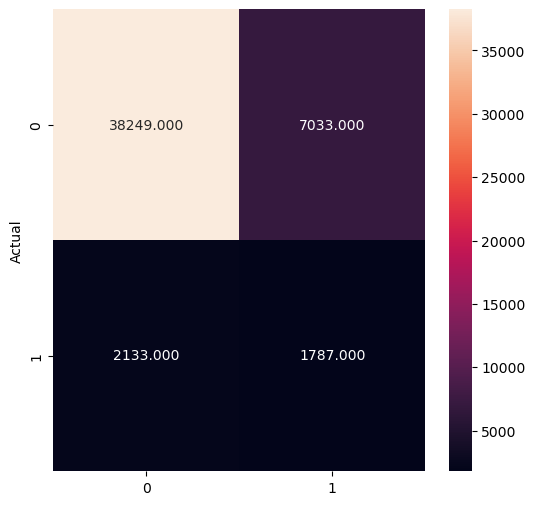

In [64]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.3f')
plt.ylabel('Actual')

Confusion matrix, without normalization
[[38249  7033]
 [ 2133  1787]]
Normalized confusion matrix
[[0.84468442 0.15531558]
 [0.54413265 0.45586735]]


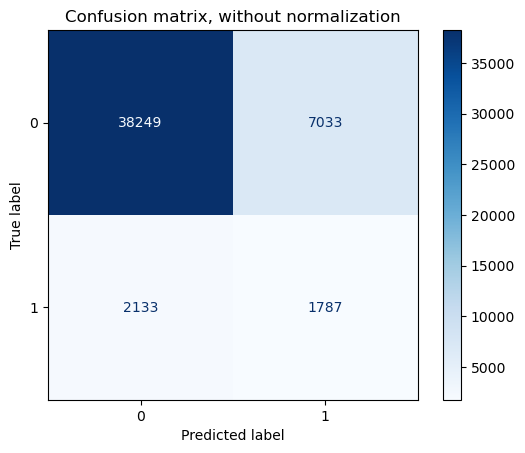

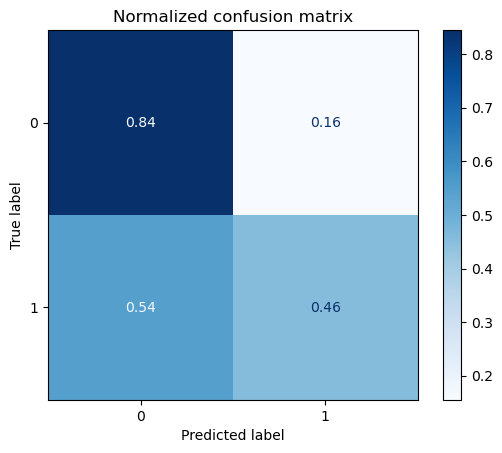

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

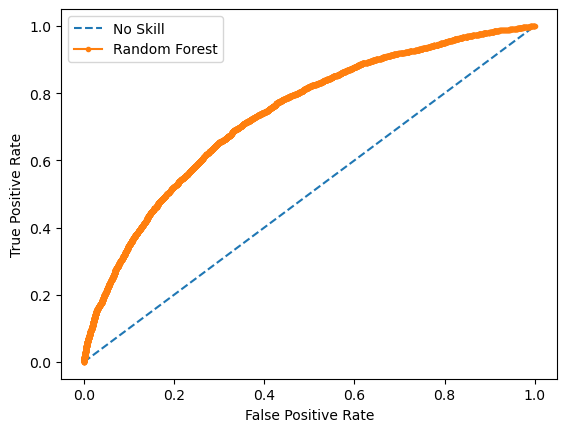

In [66]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [68]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.362932, G-Mean=0.678


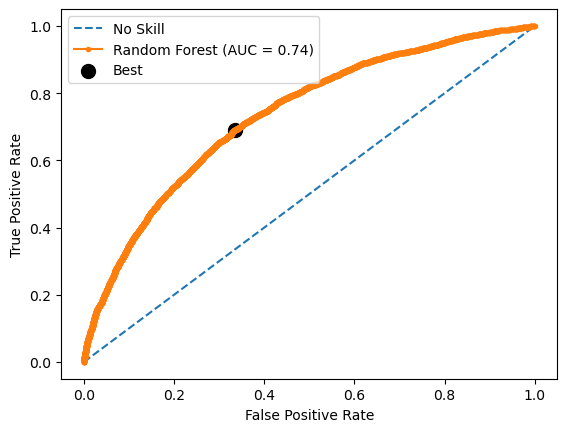

In [69]:

# calculate AUC
roc_auc = roc_auc_score(y_val, yhat)


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')    ## Caso de aleatoriedad
plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {roc_auc:.2f})')   
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Precision Curve

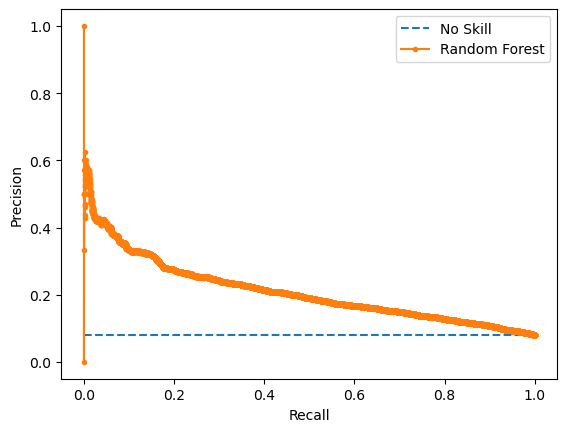

In [70]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, yhat)

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

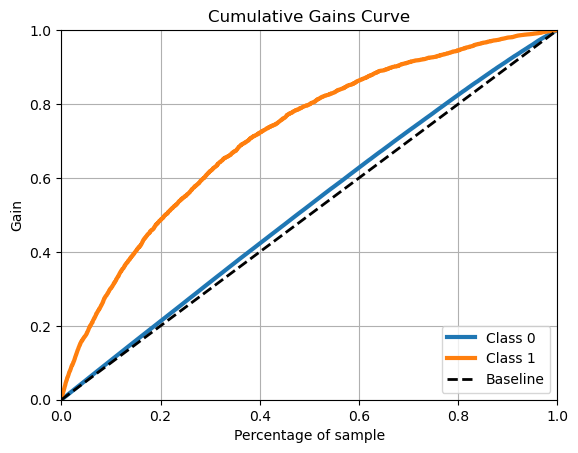

In [71]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(y_val, prob_predictions)
plt.show()

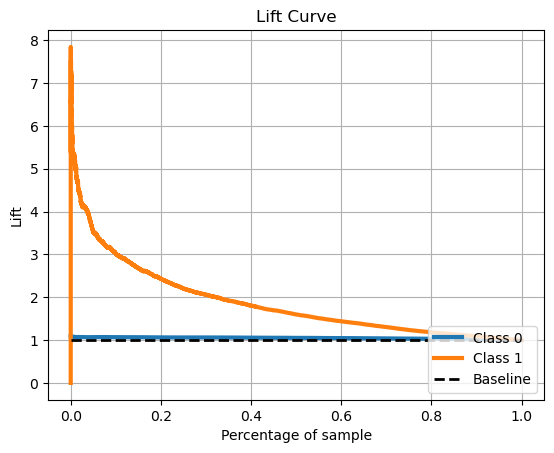

In [72]:
skplt.metrics.plot_lift_curve(y_val, prob_predictions)
plt.show()

# 4. - Explicabilidad - SHAP

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.

 The sum of all SHAP values will be equal to E[f(x)] — f(x).

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [73]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
## Definimos como va a ser el explicador 
explainer = shap.LinearExplainer(CV.best_estimator_.named_steps['classifier'], X_resampled)
print(explainer)

TypeError: __init__() missing 1 required positional argument: 'masker'

In [ ]:
## Calcula los valores shap de nuestro explicador par los variables independientes de validación
## The explainer variable will have three attributes: .values, .base_values and .data
##  - .dataattribute is simply a copy of the input data
##  - .base_values is the expected value of the target, or the average target value of all the train data
##  - .values are the SHAP values for each example
shap_values = explainer.shap_values(X_val)
print(shap_values)

[[ 2.06858801e-02  1.60189065e-01  3.24138898e-03 ... -4.01732562e-02
   3.90617077e-02  6.07201348e-02]
 [-1.22832777e+00 -1.87724118e-01  1.31070919e+00 ... -3.07320553e-01
   2.95407998e-01 -1.90917229e-01]
 [-1.40216548e+00 -1.89002307e-01  1.59937091e+00 ... -3.07320553e-01
   2.95407998e-01  6.07201348e-02]
 ...
 [-1.21466450e+00 -1.33941862e-01  1.29372908e+00 ... -4.01732562e-02
   3.90617077e-02  6.07201348e-02]
 [ 1.83595986e+00  1.38853143e-01 -1.54194782e+00 ...  6.66856627e-02
  -6.34768085e-02  6.07201348e-02]
 [ 4.40804205e+00  3.08016526e-01 -4.88702777e+00 ... -1.47032175e-01
   1.41600224e-01  6.07201348e-02]]


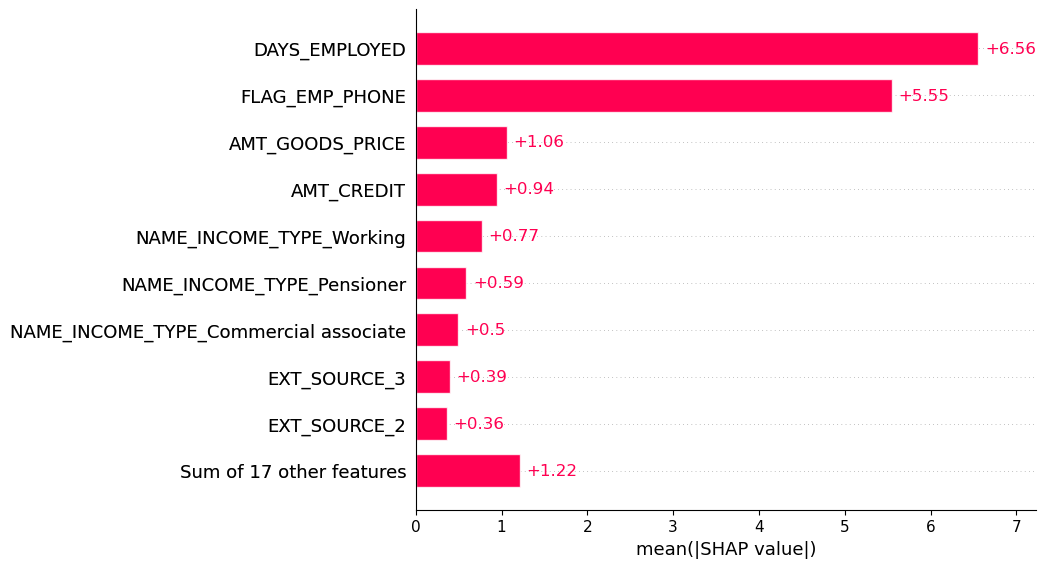

In [117]:
# shap.Explanation es una estructura de datos de SHAP que organiza la información necesaria para interpretar y visualizar los valores SHAP de un modelo.
# Combina los valores SHAP con datos adicionales como valores base, características originales
# y nombres de las mismas, proporcionando un formato estándar para la visualización y el análisis.

# Crear un objeto Explanation
shap_exp = shap.Explanation(
    values=shap_values,     ## valores SHAP
    base_values=explainer.expected_value,   ## Valore medio esperado antes de recibir ninguna caract.
    data=X_val,
    feature_names=X_val.columns
)

# Generar el gráfico de barras
shap.plots.bar(shap_exp)

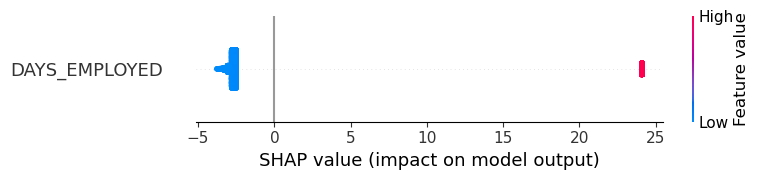

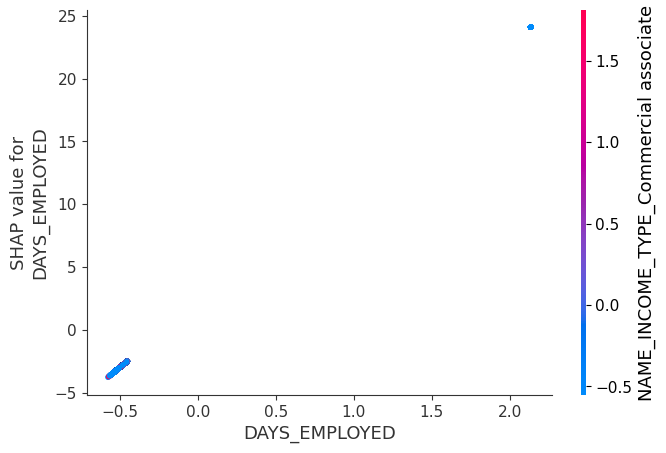

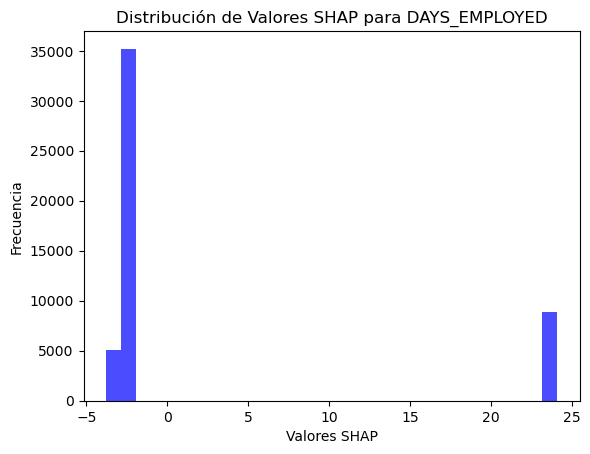

In [129]:
# Seleccionar una instancia (por ejemplo, la primera fila)
## instance_idx = 'DAYS_EMPLOYED'  # Cambia este índice para analizar otras instancias
## shap_instance = shap_values[instance_idx]

# Seleccionar la característica deseada
feature_name = 'DAYS_EMPLOYED'

# Obtener el índice de la característica en el dataset
feature_idx = X_val.columns.get_loc(feature_name)

# Extraer todos los valores SHAP correspondientes a la característica
feature_shap_values = shap_values[:, feature_idx]

# Crear un gráfico resumen (beeswarm) solo para la característica seleccionada
shap.summary_plot(
    shap_values=np.expand_dims(feature_shap_values, axis=1), 
    features=X_val[[feature_name]],
    feature_names=[feature_name]
)

# Gráfico de dependencia para 'DAYS_EMPLOYED'
shap.dependence_plot(
    feature_name,          # Nombre de la característica
    shap_values,           # Todos los valores SHAP (puede incluir varias características)
    X_val                  # Dataset original
)

import matplotlib.pyplot as plt

plt.hist(shap_values[:, feature_idx], bins=30, color='blue', alpha=0.7)
plt.title(f'Distribución de Valores SHAP para {feature_name}')
plt.xlabel('Valores SHAP')
plt.ylabel('Frecuencia')
plt.show()

In [80]:
X_val.iloc[0,:]

AMT_CREDIT                              -7.392974e-02
AMT_ANNUITY                              8.742889e-01
AMT_GOODS_PRICE                         -9.204404e-02
NAME_INCOME_TYPE_Working                -1.033175e+00
NAME_INCOME_TYPE_State servant          -2.748005e-01
NAME_INCOME_TYPE_Pensioner              -4.686088e-01
NAME_INCOME_TYPE_Commercial associate    1.813187e+00
DAYS_EMPLOYED                           -4.690384e-01
FLAG_EMP_PHONE                           4.687378e-01
REGION_RATING_CLIENT_W_CITY             -2.051897e+00
ORGANIZATION_TYPE                        1.085138e+00
EXT_SOURCE_1                             1.386448e+00
EXT_SOURCE_2                             7.387413e-01
EXT_SOURCE_3                            -5.472402e-01
APARTMENTS_AVG                          -1.913902e-01
BASEMENTAREA_AVG                        -5.225548e-16
ENTRANCES_AVG                           -7.877002e-16
NONLIVINGAREA_AVG                       -2.308827e-01
BASEMENTAREA_MODE           

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0,:])

**En una regresión logística binaria, expected_value es un escalar y no un vector. Esto sucede porque el modelo solo tiene una salida, correspondiente a la probabilidad de la clase positiva**. Por tanto no necesio específicar el que número de valor esperado cojo, si fuera
un árbol de decisión el modelo puede manejar múltiples salidas o clases en una clasificación multiclase. Por esta razón, expected_value es un vector que contiene un valor base para cada clase. Cada valor base representa la predicción promedio de esa clase antes de que las características específicas ajusten el resultado. Tendriamos:
- expected_value[0] para la primera clase.
- expected_value[n] así para cadda posible clase.

En modelos con múltiples salidas (por ejemplo, clasificación multiclase), expected_value sería un vector que contiene un valor base para cada clase. En esos casos, necesitaría especificar el índice para seleccionar el valor base correspondiente a una clase específica (por ejemplo, [0] para la clase positiva en binaria o la primera clase en multiclase).

In [145]:
## shap_values[:100,:] --> de las primera 100 instancias -- Extrae los valores shap
## X_val.iloc[:100, :] --> solo pasamos la 100 primeras filas del df

shap.force_plot(explainer.expected_value, shap_values[:200,:], features=X_val.iloc[:200, :])

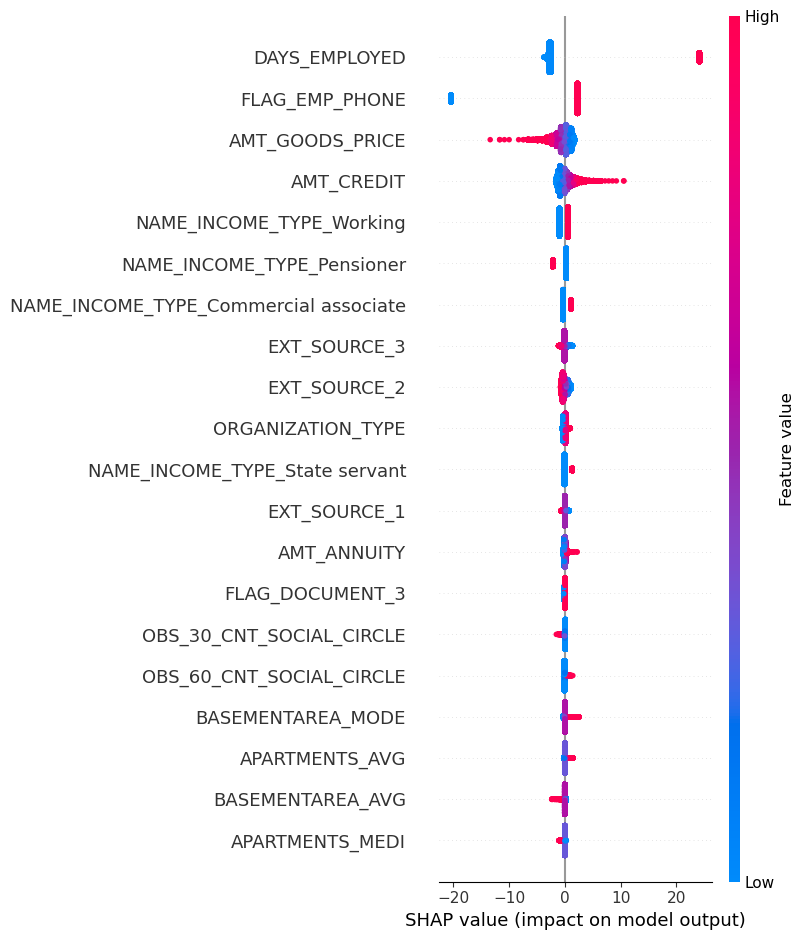

In [116]:
shap.summary_plot(shap_values, features=X_val)


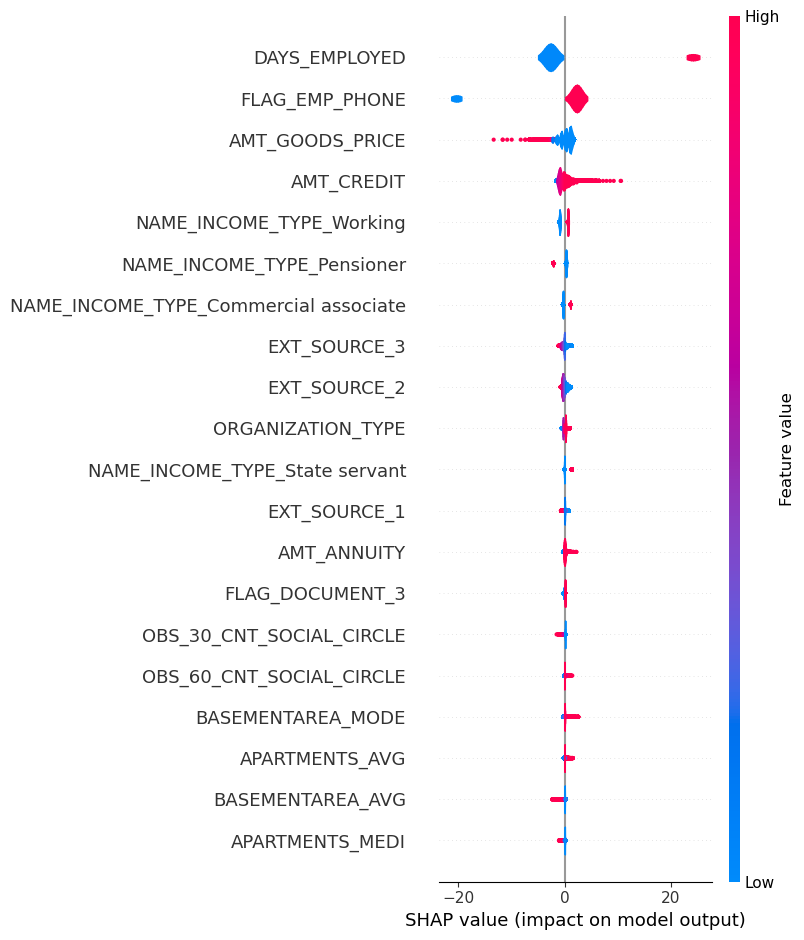

In [130]:
shap.summary_plot(shap_values, features= X_val, plot_type='violin')